# Research Request - Non-Revenue Vehicle Fleet Sizes #1236

How many non-revenue vehicles do transit agencies have. 

Also known as "service vehicles", Non-revenue vehicle data are excluded from UPT, VRM, VRH reports (since these NRV are not meant to carry passengers or make revenue).

NRVs are like support vehicles used to maintain transit operations (service/maintenance vehicles, other support.

Service Vehicle Inventory (Form A-35): "Transit agencies are required to report data on service vehicles, or vehicles which do not carry passengers.


In [1]:
import requests
import json
import pandas as pd
import numpy as np
import altair as alt

from calitp_data_analysis.tables import tbls
from siuba import _, filter, count, collect, show_query
from scipy.stats import zscore # find any outliers in the data 
from shared_utils import schedule_rt_utils

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)

GCS_PATH = "gs://calitp-analytics-data/data-analyses/ntd/"

In [2]:
# ping blackcat api to get 2024 blackcat data
api_2024 = "https://services.blackcattransit.com/api/APIModules/GetNTDReportsByYear/BCG_CA/2024"

response = requests.get(api_2024)

print(response) #got 200

# parse JSON
blob_2024 = response.json()

display(
    type(blob_2024),
    len(blob_2024)
)

<Response [200]>


list

86

## Exploring the blob JSON

[ ] = arrays. use index position (0,1,2) to accesss the different elements in the array


### Ultimate goal
 get a dataframe of organization name and A35 data

In [3]:
#blob_2024["Id"] this doesnt work, need to start by serching with ints

In [4]:
#blob_2024[0] # using int will return an agency's entire submission, keep this off for now since its long



JSON structure looks like this tho

starts with a list of dictionaries
access list with int, 
access dictionary using key value

can have nesested dictionaries (dictionaries within dictionaries)
can have list of dictionaires

```
[{'ReportId': 1138,
 'Organization': 'City of Arcata',
 'ReportPeriod': '2024',
 'ReportStatus': 'Submitted',
 'ReportLastModifiedDate': '10/29/2024 1:57:17 PM',
 'NTDReportingStationsAndMaintenance': {'Data': [{'Id': 536,...
 ,
 'NTDTransitAssetManagementA15': {'Data':...
```

In [5]:
# access organiztion name
# first org is "City of Arcata"

display(
    blob_2024[0]["Organization"],
    blob_2024[30]["Organization"]
)
# this is how you access each org in the blob
# blob[0] is City of Arcata

'City of Arcata'

'City of Guadalupe'

In [6]:
# access NTDReportingA35
blob_2024[0]["NTDReportingA35"]
# what the A35 looks like for Arcata

{'Data': [{'Id': 336,
   'ReportId': 1138,
   'EquipmentName': 'Service Vehicle Ford Escape',
   'EquipmentId': 275,
   'VehicleType': 'Trucks and Other Rubber Tire Vehicles',
   'PrimaryMode': 'MB - Bus',
   'SecondaryMode': '',
   'TotalVehicles': None,
   'UsefulLifeBenchmark': False,
   'YearOfManufacture': 2005,
   'TransitAgencyCapitalResponsibility': '',
   'EstimatedCost': None,
   'YearDollarsEstimatedCost': None,
   'UsefulLifeYearsBenchMark': None,
   'UsefulLifeYearsRemaining': None,
   'LastModifiedDate': '2024-10-29T21:07:27.03'},
  {'Id': 337,
   'ReportId': 1138,
   'EquipmentName': 'Service Vehicle Ford Fusion',
   'EquipmentId': 276,
   'VehicleType': 'Automobiles',
   'PrimaryMode': 'MB - Bus',
   'SecondaryMode': '',
   'TotalVehicles': None,
   'UsefulLifeBenchmark': False,
   'YearOfManufacture': 2012,
   'TransitAgencyCapitalResponsibility': '',
   'EstimatedCost': None,
   'YearDollarsEstimatedCost': None,
   'UsefulLifeYearsBenchMark': None,
   'UsefulLifeYears

In [7]:
# accessing data portion in A35
print(len(blob_2024[0]["NTDReportingA35"]["Data"]))

blob_2024[0]["NTDReportingA35"]["Data"]

3


[{'Id': 336,
  'ReportId': 1138,
  'EquipmentName': 'Service Vehicle Ford Escape',
  'EquipmentId': 275,
  'VehicleType': 'Trucks and Other Rubber Tire Vehicles',
  'PrimaryMode': 'MB - Bus',
  'SecondaryMode': '',
  'TotalVehicles': None,
  'UsefulLifeBenchmark': False,
  'YearOfManufacture': 2005,
  'TransitAgencyCapitalResponsibility': '',
  'EstimatedCost': None,
  'YearDollarsEstimatedCost': None,
  'UsefulLifeYearsBenchMark': None,
  'UsefulLifeYearsRemaining': None,
  'LastModifiedDate': '2024-10-29T21:07:27.03'},
 {'Id': 337,
  'ReportId': 1138,
  'EquipmentName': 'Service Vehicle Ford Fusion',
  'EquipmentId': 276,
  'VehicleType': 'Automobiles',
  'PrimaryMode': 'MB - Bus',
  'SecondaryMode': '',
  'TotalVehicles': None,
  'UsefulLifeBenchmark': False,
  'YearOfManufacture': 2012,
  'TransitAgencyCapitalResponsibility': '',
  'EstimatedCost': None,
  'YearDollarsEstimatedCost': None,
  'UsefulLifeYearsBenchMark': None,
  'UsefulLifeYearsRemaining': None,
  'LastModifiedDate':

In [8]:
# accessing 1st entry in a35 data for Arcata

blob_2024[0]["NTDReportingA35"]["Data"][0]

{'Id': 336,
 'ReportId': 1138,
 'EquipmentName': 'Service Vehicle Ford Escape',
 'EquipmentId': 275,
 'VehicleType': 'Trucks and Other Rubber Tire Vehicles',
 'PrimaryMode': 'MB - Bus',
 'SecondaryMode': '',
 'TotalVehicles': None,
 'UsefulLifeBenchmark': False,
 'YearOfManufacture': 2005,
 'TransitAgencyCapitalResponsibility': '',
 'EstimatedCost': None,
 'YearDollarsEstimatedCost': None,
 'UsefulLifeYearsBenchMark': None,
 'UsefulLifeYearsRemaining': None,
 'LastModifiedDate': '2024-10-29T21:07:27.03'}

In [9]:
# accessing speficif field, equipment name, from the first entry in a35 data for Arcata

blob_2024[0]["NTDReportingA35"]["Data"][0]["EquipmentName"]

'Service Vehicle Ford Escape'

In [10]:
# can i see org name and a35 data at the same time?
display(
    blob_2024[0]["Organization"],
    blob_2024[0]["NTDReportingA35"]["Data"]
)

'City of Arcata'

[{'Id': 336,
  'ReportId': 1138,
  'EquipmentName': 'Service Vehicle Ford Escape',
  'EquipmentId': 275,
  'VehicleType': 'Trucks and Other Rubber Tire Vehicles',
  'PrimaryMode': 'MB - Bus',
  'SecondaryMode': '',
  'TotalVehicles': None,
  'UsefulLifeBenchmark': False,
  'YearOfManufacture': 2005,
  'TransitAgencyCapitalResponsibility': '',
  'EstimatedCost': None,
  'YearDollarsEstimatedCost': None,
  'UsefulLifeYearsBenchMark': None,
  'UsefulLifeYearsRemaining': None,
  'LastModifiedDate': '2024-10-29T21:07:27.03'},
 {'Id': 337,
  'ReportId': 1138,
  'EquipmentName': 'Service Vehicle Ford Fusion',
  'EquipmentId': 276,
  'VehicleType': 'Automobiles',
  'PrimaryMode': 'MB - Bus',
  'SecondaryMode': '',
  'TotalVehicles': None,
  'UsefulLifeBenchmark': False,
  'YearOfManufacture': 2012,
  'TransitAgencyCapitalResponsibility': '',
  'EstimatedCost': None,
  'YearDollarsEstimatedCost': None,
  'UsefulLifeYearsBenchMark': None,
  'UsefulLifeYearsRemaining': None,
  'LastModifiedDate':

## List comprehension to get list of org name and a35 data

In [11]:
# testing list comprehension to access org name and a35 data

filtered_data = [
    {
        "Organization":i["Organization"], 
        "data":i["NTDReportingA35"]["Data"]
    } for i in blob_2024
]


In [12]:
# checking len of list
display(
    len(filtered_data), # 86 orgs
    len(filtered_data[0]["data"]), # 3 entries in org 0
    filtered_data[0]["Organization"]
)

86

3

'City of Arcata'

In [13]:
range(len(filtered_data))

range(0, 86)

In [14]:
for i in range(len(filtered_data)):
    if len(filtered_data[i]["data"])>0:
        print(filtered_data[i]["Organization"],",", len(filtered_data[i]["data"])) # 19 agencies, 

# since this is a list, cant use regular pandas methods.
# List of agencies with count of services vehicles greater than zero

City of Arcata , 3
Humboldt Transit Authority , 10
Mendocino Transit Authority , 9
Lassen Transit Service Agency , 1
Colusa County Transit Agency , 2
County of Nevada Public Works, Transit Services Division , 6
San Benito County Local Transportation Authority , 1
Fresno County Rural Transit Agency , 3
Morongo Basin Transit Authority , 8
Mountain Area Regional Transit Authority , 13
City of Ridgecrest , 1
Eastern Sierra Transit Authority , 9
Amador Transit , 3
Tuolumne County Transit Agency (TCTA) , 1
County of Siskiyou , 5
Trinity County Department of Transportation  , 1
Tehama County Transit Agency , 1
Calaveras Transit Agency  , 1
Palo Verde Valley Transit Agency , 6


In [15]:
#for i in range(len(filtered_data)):
#    if filtered_data[i]["data"] is not None:
#        print(filtered_data[i]["Organization"],",", len(filtered_data[i]["data"]) )

# List of agencies with count of services vehicles not Null
# confirming the previous loop is accurate, commenting out for now

## Test of using `pd.json_normalize`
data = unserialiszed JSON object

In [16]:
df_blob = pd.json_normalize(
    blob_2024,
    record_path = ["NTDReportingA35", "Data"],
    meta="Organization",
    
)

In [17]:
display(
    len(df_blob),
    type(df_blob),
    df_blob.info(),
    df_blob.describe()
)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Id                                  84 non-null     int64  
 1   ReportId                            84 non-null     int64  
 2   EquipmentName                       84 non-null     object 
 3   EquipmentId                         84 non-null     int64  
 4   VehicleType                         84 non-null     object 
 5   PrimaryMode                         78 non-null     object 
 6   SecondaryMode                       61 non-null     object 
 7   TotalVehicles                       17 non-null     float64
 8   UsefulLifeBenchmark                 84 non-null     bool   
 9   YearOfManufacture                   84 non-null     int64  
 10  TransitAgencyCapitalResponsibility  68 non-null     object 
 11  EstimatedCost                       16 non-null

84

pandas.core.frame.DataFrame

None

,Id,ReportId,EquipmentId,TotalVehicles,YearOfManufacture,EstimatedCost,YearDollarsEstimatedCost,UsefulLifeYearsBenchMark,UsefulLifeYearsRemaining
count,84.000000,84.000000,84.000000,17.000000,84.000000,16.000000,7.000000,17.000000,17.000000
mean,295.928571,1069.428571,191.666667,0.882353,2012.440476,42697.462500,2022.285714,9.941176,-0.176471
std,30.986505,42.913835,69.657913,0.485071,7.445143,26523.282861,0.755929,6.675240,4.952718
min,247.000000,1011.000000,67.000000,-1.000000,1988.000000,2500.000000,2022.000000,5.000000,-8.000000
25%,267.750000,1044.000000,129.000000,1.000000,2007.750000,34675.000000,2022.000000,5.000000,-4.000000
50%,295.500000,1054.000000,201.500000,1.000000,2013.000000,35000.000000,2022.000000,8.000000,0.000000
75%,327.250000,1109.500000,238.250000,1.000000,2018.000000,48384.500000,2022.000000,8.000000,1.000000
max,348.000000,1139.000000,303.000000,1.000000,2024.000000,120000.000000,2024.000000,27.000000,11.000000


In [18]:
df_blob["Organization"].nunique() # 19, same number of agencies in filtered_data list 

19

In [19]:
df_blob["EquipmentId"].count() # 84 service vehicles in 19 agencies

84

## Querying `fct_vehicles_type_count_by_agency`

has a column called `total_service_vehicles`

In [20]:
keep_cols=[
    "ntd_id",
    "agency",
    "city",
    "organization_type",
    "reporter_type",
    #"agency_voms",
    "total_revenue_vehicles",
    "total_service_vehicles"
]

ntd_service_veh = (
    tbls.mart_ntd_annual_reporting.fct_vehicles_type_count_by_agency()
    >> filter(
        _.state == 'CA',
        _.report_year == 2023
    )
    >> collect()
)[keep_cols].reset_index(drop=True)


In [21]:
ntd_service_veh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ntd_id                  225 non-null    object 
 1   agency                  225 non-null    object 
 2   city                    224 non-null    object 
 3   organization_type       225 non-null    object 
 4   reporter_type           225 non-null    object 
 5   total_revenue_vehicles  225 non-null    float64
 6   total_service_vehicles  225 non-null    float64
dtypes: float64(2), object(5)
memory usage: 12.4+ KB


## getting annually reported UPT and VRH from `mart_ntd_annual_reporting.fct_metrics`

In [22]:
keep_cols_2=[
    "ntd_id",
    "agency",
    "city",
    "organization_type",
    "reporter_type",
    "mode",
    "type_of_service",
    "unlinked_passenger_trips",
    "vehicle_revenue_hours",

]

ntd_ridership_metrics = (
    tbls.mart_ntd_annual_reporting.fct_metrics()
    >> filter(
        _.state == 'CA',
        _.report_year == 2023
    )
    >> collect()
)[keep_cols_2].reset_index(drop=True)

In [23]:
ntd_ridership_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ntd_id                    424 non-null    object 
 1   agency                    424 non-null    object 
 2   city                      422 non-null    object 
 3   organization_type         424 non-null    object 
 4   reporter_type             424 non-null    object 
 5   mode                      424 non-null    object 
 6   type_of_service           424 non-null    object 
 7   unlinked_passenger_trips  424 non-null    float64
 8   vehicle_revenue_hours     424 non-null    float64
dtypes: float64(2), object(7)
memory usage: 29.9+ KB


In [24]:
# aggregate UPT and VRM by agency

upt_by_agency = ntd_ridership_metrics.groupby(["ntd_id","agency"]).agg({
    "unlinked_passenger_trips":"sum",
    "vehicle_revenue_hours":"sum"
}).reset_index()

upt_by_agency.head()

,ntd_id,agency,unlinked_passenger_trips,vehicle_revenue_hours
0,90003,"San Francisco Bay Area Rapid Transit District, dba: SF BART",50764402.0,2724074.0
1,90004,Golden Empire Transit District,3293593.0,289338.0
2,90006,Santa Cruz Metropolitan Transit District,3350026.0,214748.0
3,90008,"City of Santa Monica, dba: Big Blue Bus",7767725.0,416944.0
4,90009,"San Mateo County Transit District, dba: SamTrans",8773845.0,651839.0


## A: Total Number of Non-Revenue Vehicles
aka Service Vehicles

In [25]:
total_non_rev_veh = ntd_service_veh["total_service_vehicles"].sum()
total_non_rev_veh

5328.0

## A: Number of Non-Revenue vehicles vs GTFS service hours

anything in the warehouse that can tell me service hours?

if i have to do this myself, what tables do i need?
- earliest `start time` and latest `stop time` for each `agency`?

Spoke with Amanda about service hours and GTFS digets
- advised to see the `service hours` they used in the Digest to see if ir can be useful



In [26]:
# url pulled from gtfs digest service hour section
digest_service_hours = "gs://calitp-analytics-data/data-analyses/rt_vs_schedule/digest/total_scheduled_service_hours.parquet"

service_hours = pd.read_parquet(digest_service_hours)

service_hours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24936 entries, 0 to 24935
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 24936 non-null  object 
 1   month_year           24936 non-null  object 
 2   weekday_weekend      24936 non-null  object 
 3   departure_hour       24936 non-null  Int64  
 4   service_hours        24936 non-null  float64
 5   daily_service_hours  24936 non-null  float64
dtypes: Int64(1), float64(2), object(3)
memory usage: 1.2+ MB


In [27]:
service_hours["name"].value_counts()

Bay Area 511 SamTrans Schedule                          288
Bay Area 511 SFO AirTrain Schedule                      288
LA Metro Bus Schedule                                   288
LAX FlyAway Schedule                                    282
San Diego Schedule                                      276
Bay Area 511 Santa Clara Transit Schedule               273
Bay Area 511 Muni Schedule                              264
Bay Area 511 Marin Schedule                             264
Bay Area 511 AC Transit Schedule                        264
OCTA Schedule                                           264
Anaheim Resort Schedule                                 262
Bay Area 511 Golden Gate Transit Schedule               252
Bay Area 511 BART Schedule                              248
Riverside Schedule                                      244
North County Schedule                                   240
Yolobus Schedule                                        240
Sacramento Schedule                     

In [28]:
#group by name?

schedule_service_hours = service_hours.groupby("name").agg({
    "daily_service_hours":"sum"
}).reset_index()

schedule_service_hours.head()

,name,daily_service_hours
0,Alhambra Schedule,285.15
1,Amador Schedule,148.27
2,Amtrak Schedule,35345.12
3,Anaheim Resort Schedule,120397.39
4,Antelope Valley Transit Authority Schedule,3801.10


service hour uses schcedule name
need to crosswalk agency name/ntd id to schedule name...again


In [29]:
# via proposed_changes NB

#crosswalk from gtfs dataset key to orgs
gcs_crosswalk = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk/gtfs_key_organization_2024-10-16.parquet"
)

gcs_crosswalk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 0 to 214
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   schedule_gtfs_dataset_key          215 non-null    object 
 1   name                               215 non-null    object 
 2   schedule_source_record_id          215 non-null    object 
 3   base64_url                         215 non-null    object 
 4   organization_source_record_id      215 non-null    object 
 5   organization_name                  215 non-null    object 
 6   caltrans_district                  215 non-null    object 
 7   counties_served                    120 non-null    object 
 8   hq_city                            153 non-null    object 
 9   hq_county                          121 non-null    object 
 10  is_public_entity                   121 non-null    object 
 11  is_publicly_operating              121 non-null    object 

In [30]:
keep_cols_xwalk=[
    "schedule_source_record_id",
    "schedule_gtfs_dataset_key",
    "name",
    "base64_url",
    "organization_source_record_id",
    "organization_name",
    "caltrans_district",
    "reporter_type",
    "primary_uza_name",
    "voms_pt",
    "voms_do"
]

gcs_crosswalk = gcs_crosswalk[keep_cols_xwalk]
gcs_crosswalk.rename(columns={"name":"name_schedule"}, inplace=True)

# dim orgs
dim_orgs = (tbls.mart_transit_database.dim_organizations()
            >> filter(_._is_current == True,
                      #_.ntd_id.isin(sec_g_ntd_id), # filters to ntd_id from Sec G operators
                      _.public_currently_operating_fixed_route == True
                     )
            >> collect()
           )
                   

keep_cols_2 =[
    "key",
    "source_record_id",
    "name",
    "organization_type",
    "caltrans_district",
    "is_public_entity",
    "ntd_id",
    "reporting_category",
    "public_currently_operating_fixed_route",  
]

dim_orgs =dim_orgs[keep_cols_2]
dim_orgs.rename(columns={
    "key":"key_orgs",
    "name":"name_orgs"
}, inplace=True)

dim_orgs_to_crosswalk = dim_orgs.merge(
    gcs_crosswalk, 
    left_on="source_record_id", 
    right_on="organization_source_record_id", 
    how="left"
)

schedule_feed_xwalk = schedule_rt_utils.get_schedule_gtfs_dataset_key(date="2024-10-16")

orgs_to_feed_xwalk = dim_orgs_to_crosswalk.merge(
    schedule_feed_xwalk, 
    left_on = "schedule_gtfs_dataset_key", 
    right_on="gtfs_dataset_key", how="left"
)

In [31]:
display(
    orgs_to_feed_xwalk.info(),
    orgs_to_feed_xwalk.head()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 0 to 218
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   key_orgs                                219 non-null    object
 1   source_record_id                        219 non-null    object
 2   name_orgs                               219 non-null    object
 3   organization_type                       219 non-null    object
 4   caltrans_district_x                     217 non-null    object
 5   is_public_entity                        219 non-null    bool  
 6   ntd_id                                  179 non-null    object
 7   reporting_category                      209 non-null    object
 8   public_currently_operating_fixed_route  219 non-null    bool  
 9   schedule_source_record_id               201 non-null    object
 10  schedule_gtfs_dataset_key               201 non-null    object
 11  name_s

None

,key_orgs,source_record_id,name_orgs,organization_type,caltrans_district_x,is_public_entity,ntd_id,reporting_category,public_currently_operating_fixed_route,schedule_source_record_id,schedule_gtfs_dataset_key,name_schedule,base64_url,organization_source_record_id,organization_name,caltrans_district_y,reporter_type,primary_uza_name,voms_pt,voms_do,gtfs_dataset_key,feed_key
0,c734d54d15c1947dc0cf3c4605390d25,recS1JKEz73Hev8pJ,"University of California, Davis",University - Public,03 - Marysville,False,90142,Core,True,recpwl8uJU04SPbWS,d2b09fbd392b28d767c28ea26529b0cd,Unitrans Schedule,aHR0cHM6Ly91bml0cmFucy51Y2RhdmlzLmVkdS9tZWRpYS9ndGZzL1VuaXRyYW5zX0dURlMuemlw,recS1JKEz73Hev8pJ,"University of California, Davis",03 - Marysville,Full Reporter,"Davis, CA",<NA>,25,d2b09fbd392b28d767c28ea26529b0cd,30df8787b189ff9c8a449a1b3d700296
1,1d03fdbc2e4dfd044465b4437e70c9e0,recQRoE5mcCn6kdti,POINT,Independent Agency,01 - Eureka,True,None,Other Public Transit,True,recWPANXTwn1u1i2l,0d04ec340550e5a62b031a8e125e6658,Oregon POINT,aHR0cHM6Ly9vcmVnb24tZ3Rmcy50cmlsbGl1bXRyYW5zaXQuY29tL2d0ZnNfZGF0YS9wb2ludC1vci11cy9wb2ludC1vci11cy56aXA=,recQRoE5mcCn6kdti,POINT,01 - Eureka,None,None,<NA>,<NA>,0d04ec340550e5a62b031a8e125e6658,54a3956fcd7b59a3db76007d2f53a5dc
2,e8f13022ac8ecff976188979ac903d4a,recKsb5FnJy70up78,Amtrak,Federal Government,03 - Marysville,True,None,Other Public Transit,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN
3,f269f25681d3ed293401b3b8027f89a8,recG5aXxDPI645S86,OmniTrans,Independent Agency,08 - San Bernardino,True,90029,Core,True,recofAxeH23aWcuAP,95cb514215c61ca578b01d885f35ec0a,OmniTrans Schedule,aHR0cHM6Ly93d3cub21uaXRyYW5zLm9yZy9nb29nbGUvZ29vZ2xlX3RyYW5zaXQuemlw,recG5aXxDPI645S86,OmniTrans,08 - San Bernardino,Full Reporter,"Riverside--San Bernardino, CA",44,99,95cb514215c61ca578b01d885f35ec0a,b4192f0e3b1746c45066f5016ced9b5b
4,d4d53f5a85cec17582000a9e67a7d642,reczvlrgxLUDiBgAy,Commute.org,Joint Powers Agency,04 - Oakland,True,None,Other Public Transit,True,rec9wl7HVaxR79ayw,c2a40ce92e76ec5beb88c40df3cd3a67,Bay Area 511 Commute.org Schedule,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZWVkcz9vcGVyYXRvcl9pZD1DTQ==,reczvlrgxLUDiBgAy,Commute.org,04 - Oakland,None,None,<NA>,<NA>,c2a40ce92e76ec5beb88c40df3cd3a67,7de3f9edc864d6923e3664e3efd2f0ff


## A: Number of Non-Revenue vehicles vs NTD ridership


In [32]:
display(
    ntd_service_veh.dtypes,
    upt_by_agency.dtypes,
)

ntd_id                     object
agency                     object
city                       object
organization_type          object
reporter_type              object
total_revenue_vehicles    float64
total_service_vehicles    float64
dtype: object

ntd_id                       object
agency                       object
unlinked_passenger_trips    float64
vehicle_revenue_hours       float64
dtype: object

In [39]:
# join ntd_service_veh and upt_by_agency

service_veh_upt = ntd_service_veh.merge(upt_by_agency, on=["ntd_id","agency"], how="inner", indicator=True)
service_veh_upt.head()

,ntd_id,agency,city,organization_type,reporter_type,total_revenue_vehicles,total_service_vehicles,unlinked_passenger_trips,vehicle_revenue_hours,_merge
0,90003,"San Francisco Bay Area Rapid Transit District, dba: SF BART",Oakland,Independent Public Agency or Authority of Transit Service,Full Reporter,846.0,660.0,50764402.0,2724074.0,both
1,90004,Golden Empire Transit District,Bakersfield,Independent Public Agency or Authority of Transit Service,Full Reporter,137.0,26.0,3293593.0,289338.0,both
2,90006,Santa Cruz Metropolitan Transit District,Santa Cruz,Independent Public Agency or Authority of Transit Service,Full Reporter,125.0,41.0,3350026.0,214748.0,both
3,90008,"City of Santa Monica, dba: Big Blue Bus",Santa Monica,"City, County or Local Government Unit or Department of Transportation",Full Reporter,221.0,20.0,7767725.0,416944.0,both
4,90009,"San Mateo County Transit District, dba: SamTrans",San Carlos,Independent Public Agency or Authority of Transit Service,Full Reporter,434.0,78.0,8773845.0,651839.0,both


<AxesSubplot:xlabel='agency'>

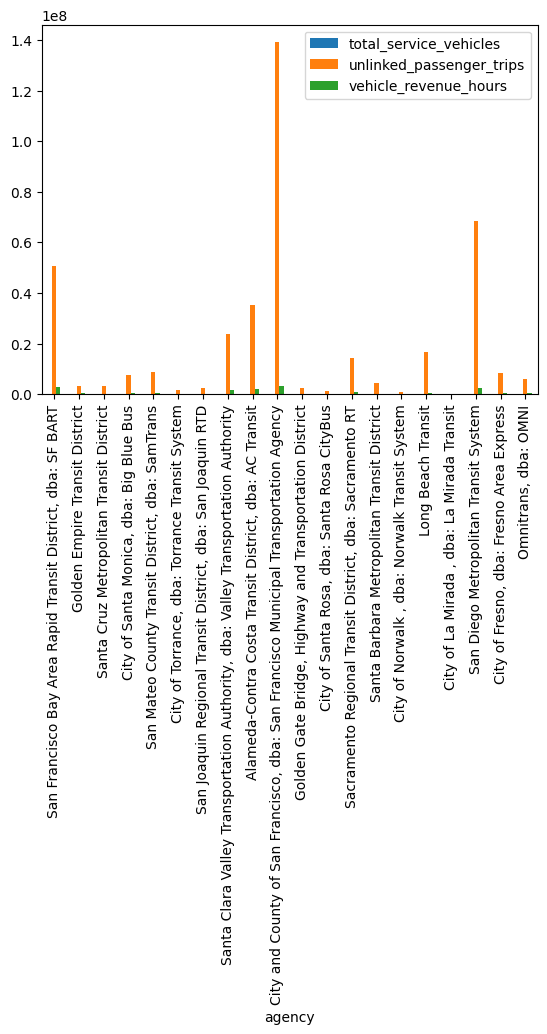

In [38]:
service_veh_upt[:20].plot(
    x = "agency",
    y = ["total_service_vehicles", "unlinked_passenger_trips","vehicle_revenue_hours"],
    kind = "bar",
    #secondary_y = "unlinked_passenger_trips"
    
)

In [42]:
z_score = service_veh_upt[[
    "vehicle_revenue_hours",
    "total_service_vehicles",
    "unlinked_passenger_trips"
]].apply(zscore)

In [45]:
threshold = 3
service_v_upt_no_outliers = service_veh_upt[(z_score.abs() < threshold).all(axis=1)]

In [52]:
display(
    "initial data",
    service_veh_upt.describe(),
    "outliers removed",
    service_v_upt_no_outliers.describe()
)
# can see that the min/max values of each col were adjusted

'initial data'

,total_revenue_vehicles,total_service_vehicles,unlinked_passenger_trips,vehicle_revenue_hours
count,209.000000,209.000000,2.090000e+02,2.090000e+02
mean,113.411483,25.473684,3.997801e+06,1.974787e+05
std,347.217418,123.424808,2.235365e+07,7.133054e+05
min,1.000000,0.000000,2.390000e+02,1.290000e+02
25%,8.000000,0.000000,2.823200e+04,6.810000e+03
50%,20.000000,1.000000,1.255200e+05,2.407500e+04
75%,60.000000,8.000000,8.388670e+05,9.376300e+04
max,4060.000000,1498.000000,2.763024e+08,8.220160e+06


'outliers removed'

,total_revenue_vehicles,total_service_vehicles,unlinked_passenger_trips,vehicle_revenue_hours
count,205.000000,205.000000,2.050000e+02,2.050000e+02
mean,79.434146,12.682927,1.467486e+06,1.192848e+05
std,173.081761,38.042056,4.351655e+06,3.015260e+05
min,1.000000,0.000000,2.390000e+02,1.290000e+02
25%,8.000000,0.000000,2.792900e+04,6.590000e+03
50%,20.000000,1.000000,1.198630e+05,2.345900e+04
75%,60.000000,8.000000,7.392380e+05,8.936800e+04
max,1289.000000,356.000000,3.519006e+07,2.076903e+06


In [51]:
chart = alt.Chart(service_v_upt_no_outliers).mark_point().encode(
    x = "total_service_vehicles",
    y = "unlinked_passenger_trips"
)

chart + chart.transform_regression("total_service_vehicles","unlinked_passenger_trips").mark_line()

alt.LayerChart(...)